## Entendimento dos Dados (Data Understanding)

`Coleta inicial dos dados, familiarização com eles, identificação de problemas de qualidade, e geração de hipóteses iniciais.`


### Dados Abertos

Como fontes e dados possíveis, temos:

* Dados abertos da PGFN, disponíveis em <https://www.gov.br/pgfn/pt-br/assuntos/divida-ativa-da-uniao/transparencia-fiscal-1/dados-abertos>
* Dados abertos da Receita (base CNPJ), disponíveis em <https://dados.gov.br/dados/conjuntos-dados/cadastro-nacional-da-pessoa-juridica---cnpj>

#### PGFN

* **FGTS:** Refere-se a débitos de empregadores com o fundo de garantia.
* **PREV (Previdenciário):** Débitos de contribuições previdenciárias.
* **SIDA:** Conjunto de dados do sistema unificado da administração federal, com dados detalhados sobre devedores e sua situação perante a União.

Layout dos arquivos:

➜ FGTS PREV e SIDA
| Campo                     | Descrição                                                                 |
|---------------------------|---------------------------------------------------------------------------|
| CPF_CNPJ                  | CPF ou CNPJ do devedor inscrito na dívida ativa.                         |
| TIPO_PESSOA               | Indica se o devedor é pessoa física (F) ou jurídica (J).                 |
| TIPO_DEVEDOR              | Categoria do devedor: contribuinte individual, empresa, órgão público etc. |
| NOME_DEVEDOR              | Nome ou razão social do devedor.                                         |
| UF_DEVEDOR                | Unidade da Federação (estado) do devedor.                               |
| UNIDADE_RESPONSAVEL       | Unidade da PGFN responsável pela inscrição da dívida.                   |
| NUMERO_INSCRICAO          | Número único da inscrição da dívida ativa.                              |
| TIPO_SITUACAO_INSCRICAO   | Tipo da situação da inscrição: ativa, suspensa, extinta etc.            |
| SITUACAO_INSCRICAO        | Descrição detalhada da situação atual da dívida.                        |
| TIPO_CREDITO              | Tipo de crédito tributário ou não tributário (ex: FGTS, Multas).        |
| DATA_INSCRICAO            | Data da inscrição na dívida ativa.                                      |
| INDICADOR_AJUIZADO        | Indica se a dívida foi ajuizada: 'S' ou 'N'.                            |
| VALOR_CONSOLIDADO         | Valor total da dívida com acréscimos legais.                            |

➜ FGTS
| Campo                  | Descrição                                           |
|------------------------|---------------------------------------------------|
| ENTIDADE_RESPONSAVEL   | Entidade que gerou a inscrição do débito FGTS.    |
| UNIDADE_INSCRICAO      | Unidade/agência que realizou a inscrição do débito FGTS. |



#### CNPJ (Receita) 

**ideias:**
UF_DEVEDOR: tentar análise geográfica, indicando que alguns estados têm mais devedores. baixar dados do IBGE
UNIDADE_RESPONSAVEL: tentar analisar a carga de dívidas por unidade da PGFN.
SITUACAO_INSCRICAO: será que o status da dívida e como isso impacta a cobrança ou ajuizamento.
TIPO_CREDITO: tentar ver risco associado a diferentes tipos de crédito.

Tentar juntar com CNAE

### Exploratory

In [4]:
import sys
import os

import networkx as nx
from collections import Counter
from networkx.drawing.nx_agraph import graphviz_layout

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

from modules.utils.file import (
        find_zip_files_by_pattern,
        read_zip_csvs_as_df,
        save_parquet
)

from modules.utils.dataframe import (
    dataframe_info
)

from modules.utils.plot.style import ( 
    set_plot_style,
)

from modules.utils.plot.save import ( 
    save_figure
)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.float_format = '{:,.2f}'.format
set_plot_style()
os.makedirs('reports/figures', exist_ok=True)

# data_root = os.path.abspath(os.path.join(os.getcwd(), '..', 'data'))
data_root = '/home/nicolas/Documents/dados/pgfn/'


#### Load Data 

In [5]:
zip_files = find_zip_files_by_pattern(directory=f"{data_root}/dados/", pattern='FGTS.zip')
all_dfs = []

for f in zip_files:
    print(f"Processando arquivo: {f}")
    df = read_zip_csvs_as_df(f, encoding='latin1', verbose=False)
    all_dfs.append(df)

dadosDF = pd.concat(all_dfs, ignore_index=True)

Processando arquivo: /home/nicolas/Documents/dados/pgfn//dados/2020T2_Dados_abertos_FGTS.zip
Processando arquivo: /home/nicolas/Documents/dados/pgfn//dados/2020T1_Dados_abertos_FGTS.zip


In [6]:
dadosDF['CPF_CNPJ'] = (
    dadosDF['CPF_CNPJ']
    .astype(str)
    .str.replace(r'\D', '', regex=True)
    .where(dadosDF['CPF_CNPJ'].notna())
)
dadosDF['DATA_INSCRICAO'] = pd.to_datetime(dadosDF['DATA_INSCRICAO'], format="%d/%m/%Y", errors='coerce')

dataframe_info(dadosDF)

Variáveis categóricas:
['CPF_CNPJ', 'TIPO_PESSOA', 'TIPO_DEVEDOR', 'NOME_DEVEDOR', 'UF_UNIDADE_RESPONSAVEL', 'UNIDADE_RESPONSAVEL', 'ENTIDADE_RESPONSAVEL', 'UNIDADE_INSCRICAO', 'NUMERO_INSCRICAO', 'TIPO_SITUACAO_INSCRICAO', 'SITUACAO_INSCRICAO', 'RECEITA_PRINCIPAL', 'INDICADOR_AJUIZADO', '__source_file__']

Número de categorias únicas:
CPF_CNPJ                   244967
TIPO_PESSOA                     2
TIPO_DEVEDOR                    1
NOME_DEVEDOR               220548
UF_UNIDADE_RESPONSAVEL         27
UNIDADE_RESPONSAVEL           111
ENTIDADE_RESPONSAVEL            2
UNIDADE_INSCRICAO             111
NUMERO_INSCRICAO           445302
TIPO_SITUACAO_INSCRICAO         4
SITUACAO_INSCRICAO             10
RECEITA_PRINCIPAL               2
INDICADOR_AJUIZADO              2
__source_file__                56
dtype: int64

>>>>> CPF_CNPJ <<<<<
Total de categorias: 244967
CPF_CNPJ
30477954000150    0.01%
61575775000180    0.01%
60477056000163    0.01%
96653894000198    0.01%
92219070000153    

#### Variáveis Categóricas

##### Avaliando Indicador Ajuizado (Análise Bivariada)

In [7]:
df = dadosDF

##### Proporção por Indicador Ajuizado

In [8]:
proporcao = (
    df['INDICADOR_AJUIZADO']
    .astype(str)
    .str.strip()
    .str.upper()
    .replace({'NÃO': 'NAO', 'SIM': 'SIM'})  # garante correspondência com cmap
    .value_counts(normalize=True) * 100
)
proporcao

INDICADOR_AJUIZADO
SIM   80.57
NAO   19.43
Name: proportion, dtype: float64

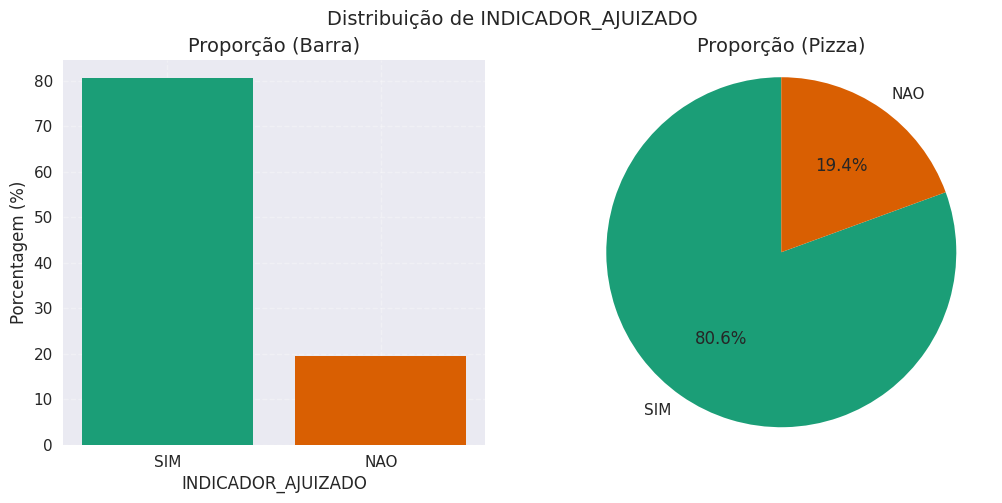

In [9]:
categorias = proporcao.index.tolist()
valores = proporcao.values

cmap = {
    'SIM': '#1b9e77',
    'NAO': '#d95f02',
}
cores = [cmap.get(v, '#333') for v in categorias] 

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Gráfico de barras
axs[0].bar(categorias, valores, color=cores)
axs[0].set_title("Proporção (Barra)")
axs[0].set_ylabel("Porcentagem (%)")
axs[0].set_xlabel("INDICADOR_AJUIZADO")

# Gráfico de pizza
axs[1].pie(valores, labels=categorias, autopct='%1.1f%%', startangle=90, colors=cores)
axs[1].axis('equal')  # Para pizza redonda
axs[1].set_title("Proporção (Pizza)")

fig.suptitle("Distribuição de INDICADOR_AJUIZADO", fontsize=14)

save_figure(fig, "distribuicao_indicador_ajuizado", formats=['png'])
plt.show()

###### Proporção por Situação

In [10]:
#proporcao por situacao
result = pd.crosstab(df['SITUACAO_INSCRICAO'], df['INDICADOR_AJUIZADO'])
print(result)

INDICADOR_AJUIZADO     NAO     SIM
SITUACAO_INSCRICAO                
AJUIZ PARCELADA          0   14984
AJUIZADA                 0  693916
EMBARGADA                0    1757
ENC PROTESTO             5       0
INSCR PARCELADA       7485       0
INSCRITA            152510       0
OUTROS AJUIZADA          0     140
OUTROS INSCRITA        146       0
PETICIONADA          11224       0
TRANSFERIDA             31       0


In [11]:
#proporcao por situacao
result = pd.crosstab(df['SITUACAO_INSCRICAO'], df['INDICADOR_AJUIZADO'], normalize='index')

result *= 100
result

INDICADOR_AJUIZADO,NAO,SIM
SITUACAO_INSCRICAO,,
AJUIZ PARCELADA,0.00,100.00
AJUIZADA,0.00,100.00
EMBARGADA,0.00,100.00
ENC PROTESTO,100.00,0.00
INSCR PARCELADA,100.00,0.00
INSCRITA,100.00,0.00
OUTROS AJUIZADA,0.00,100.00
OUTROS INSCRITA,100.00,0.00
PETICIONADA,100.00,0.00


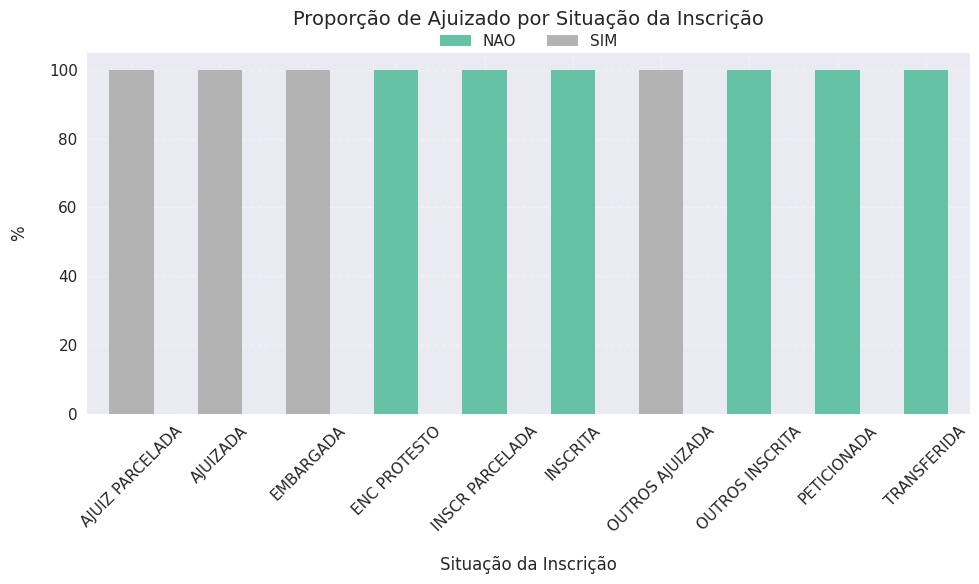

In [12]:
fig = plt.figure(figsize=(10, 6))
result.plot(kind='bar', stacked=True, colormap='Set2', ax=plt.gca())

plt.title('Proporção de Ajuizado por Situação da Inscrição', pad=20)
plt.xlabel('Situação da Inscrição', labelpad=15)
plt.ylabel('%', labelpad=15)
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(0.5, 1.09), loc='upper center',ncol=2)
plt.tight_layout()
save_figure(fig, "indicador_ajuizado_por_situcacao_inscricao", formats=['png'])


##### Proporção por UF Unidade Responsavel

In [13]:
# proporcao por UF


result = df.groupby('UF_UNIDADE_RESPONSAVEL')['INDICADOR_AJUIZADO'] \
    .value_counts(normalize=True) \
    .unstack() \
    # .sort_values('SIM', ascending=False)

result *= 100
result

INDICADOR_AJUIZADO,NAO,SIM
UF_UNIDADE_RESPONSAVEL,,
AC,44.48,55.52
AL,39.77,60.23
AM,26.54,73.46
AP,41.79,58.21
BA,45.05,54.95
CE,28.46,71.54
DF,35.89,64.11
ES,45.69,54.31
GO,32.72,67.28


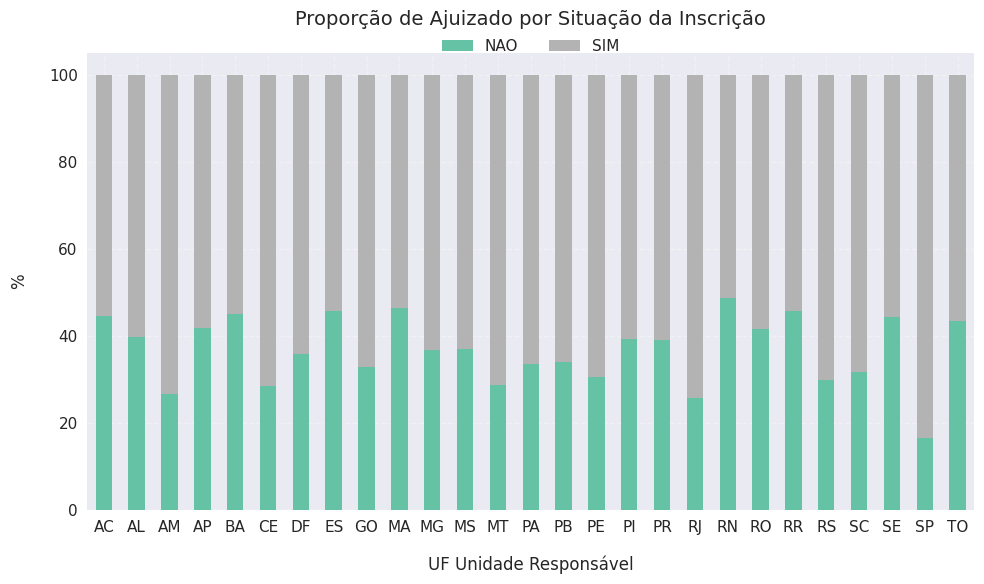

In [14]:
ax = result.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='Set2')
plt.title('Proporção de Ajuizado por Situação da Inscrição', pad=20)
plt.xlabel('UF Unidade Responsável', labelpad=15)
plt.ylabel('%', labelpad=15)
plt.xticks(rotation=0)
plt.legend(bbox_to_anchor=(0.5, 1.06), loc='upper center', ncol=2)
plt.tight_layout()
plt.show()
save_figure(fig, "indicador_ajuizado_por_uf_unidade_responsavel", formats=['png'])




##### Proporção por Situação

##### Proporção por Valor Consolidado

In [15]:
result = df.groupby('INDICADOR_AJUIZADO')['VALOR_CONSOLIDADO'].describe().T
result

INDICADOR_AJUIZADO,NAO,SIM
count,"171,401.00","710,797.00"
mean,"63,490.37","89,854.15"
std,"724,510.57","773,015.54"
min,0.02,0.03
25%,"1,811.94","3,241.74"
50%,"4,626.07","11,470.96"
75%,"12,218.02","40,473.67"
max,"62,962,420.82","153,093,627.92"


VALOR_CONSOLIDADO possui valores extremos

In [16]:
filtered_df = df[(df['VALOR_CONSOLIDADO'] < 2) & (df['SITUACAO_INSCRICAO'] == 'AJUIZADA')]
filtered_df

,CPF_CNPJ,TIPO_PESSOA,TIPO_DEVEDOR,NOME_DEVEDOR,UF_UNIDADE_RESPONSAVEL,UNIDADE_RESPONSAVEL,ENTIDADE_RESPONSAVEL,UNIDADE_INSCRICAO,NUMERO_INSCRICAO,TIPO_SITUACAO_INSCRICAO,SITUACAO_INSCRICAO,RECEITA_PRINCIPAL,DATA_INSCRICAO,INDICADOR_AJUIZADO,VALOR_CONSOLIDADO,__source_file__
276829,00851757000199,Pessoa jurídica,Principal,OLICO RENOVADORA DE PNEUS LTDA,PE,5ª REGIÃO,PGFN,5ª REGIÃO,CSPE200600220,Em cobrança,AJUIZADA,Contribuições LC110 (FGTS),2006-11-14,SIM,1.04,arquivo_lai_FGTS_PE_202006.csv
409620,04420429000199,Pessoa jurídica,Principal,GRASIELE RAPHAELA FANDI & CIA LTDA,SP,SOROCABA,PGFN,SOROCABA,CSSP200902199,Em cobrança,AJUIZADA,Contribuições LC110 (FGTS),2009-04-16,SIM,1.24,arquivo_lai_FGTS_SP_202006.csv
714276,00851757000199,Pessoa jurídica,Principal,OLICO RENOVADORA DE PNEUS LTDA,PE,5ª REGIÃO,PGFN,5ª REGIÃO,CSPE200600220,Em cobrança,AJUIZADA,Contribuições LC110 (FGTS),2006-11-14,SIM,1.04,arquivo_lai_FGTS_PE_202002.csv
842767,04420429000199,Pessoa jurídica,Principal,GRASIELE RAPHAELA FANDI & CIA LTDA,SP,SOROCABA,PGFN,SOROCABA,CSSP200902199,Em cobrança,AJUIZADA,Contribuições LC110 (FGTS),2009-04-16,SIM,1.23,arquivo_lai_FGTS_SP_202002.csv


#### Avalise Variaveis Numéricas

In [17]:
df = dadosDF

In [18]:
result = df.groupby('INDICADOR_AJUIZADO')['VALOR_CONSOLIDADO'].describe().T
result

INDICADOR_AJUIZADO,NAO,SIM
count,"171,401.00","710,797.00"
mean,"63,490.37","89,854.15"
std,"724,510.57","773,015.54"
min,0.02,0.03
25%,"1,811.94","3,241.74"
50%,"4,626.07","11,470.96"
75%,"12,218.02","40,473.67"
max,"62,962,420.82","153,093,627.92"


/tmp/ipykernel_29578/864337641.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='INDICADOR_AJUIZADO', y='VALOR_CONSOLIDADO', palette='Set2')


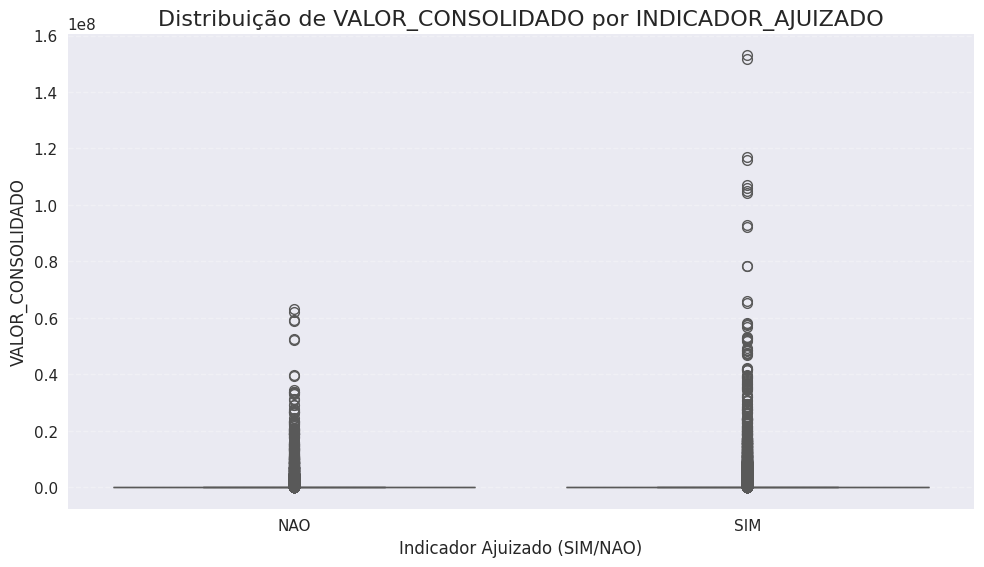

In [19]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x='INDICADOR_AJUIZADO', y='VALOR_CONSOLIDADO', palette='Set2')
plt.title('Distribuição de VALOR_CONSOLIDADO por INDICADOR_AJUIZADO', fontsize=16)
plt.xlabel('Indicador Ajuizado (SIM/NAO)', fontsize=12)
plt.ylabel('VALOR_CONSOLIDADO', fontsize=12)
plt.tight_layout()
plt.show()

In [20]:
#Visualizando padroes para cada situacao

situacoes = [
    'AJUIZ PARCELADA', 'AJUIZADA', 'EMBARGADA', 'ENC PROTESTO', 
    'INSCR PARCELADA', 'INSCRITA', 'OUTROS AJUIZADA', 'OUTROS INSCRITA',
    'PETICIONADA', 'TRANSFERIDA'
]
resultados = {}
for situacao in situacoes:
    filtered_df = df[df['SITUACAO_INSCRICAO'] == situacao]
    result = filtered_df.groupby('INDICADOR_AJUIZADO')['VALOR_CONSOLIDADO'].describe().T
    resultados[situacao] = result

for situacao, result in resultados.items():
    print(f"Descrição para SITUACAO_INSCRICAO = {situacao}:")
    print(result)
    print("\n" + "="*50 + "\n")


Descrição para SITUACAO_INSCRICAO = AJUIZ PARCELADA:
INDICADOR_AJUIZADO           SIM
count                  14,984.00
mean                  144,544.71
std                   742,111.71
min                         0.03
25%                     6,116.02
50%                    21,947.62
75%                    61,380.00
max                18,770,124.48


Descrição para SITUACAO_INSCRICAO = AJUIZADA:
INDICADOR_AJUIZADO            SIM
count                  693,916.00
mean                    86,412.03
std                    737,030.98
min                          1.04
25%                      3,206.79
50%                     11,249.23
75%                     39,831.85
max                153,093,627.92


Descrição para SITUACAO_INSCRICAO = EMBARGADA:
INDICADOR_AJUIZADO            SIM
count                    1,757.00
mean                   986,498.27
std                  4,656,418.94
min                         10.15
25%                     16,253.56
50%                     70,454.68
75%      

### Features

In [21]:
cnpj_counts = final_df['CPF_CNPJ'].value_counts()
duplicate_cnpjs = cnpj_counts[cnpj_counts > 1]
print(f"\nCPF_CNPJs duplicados:")
print(duplicate_cnpjs)

duplicate_rows = final_df[final_df['CPF_CNPJ'].isin(duplicate_cnpjs.index)]



NameError: name 'final_df' is not defined

In [ ]:
duplicate_rows.loc[duplicate_rows['CPF_CNPJ'] == '26925503000161']

In [ ]:
count = final_df['NUMERO_INSCRICAO'].value_counts()
duplicates = count[count > 1]
print(duplicates)

duplicate_rows = final_df[final_df['NUMERO_INSCRICAO'].isin(duplicates.index)]


In [ ]:
duplicate_rows.loc[duplicate_rows['NUMERO_INSCRICAO'] == 'FGTO201500125']

In [ ]:
situacao_df = final_df[[
    'NUMERO_INSCRICAO',
    'ANOMES',
    'SITUACAO_INSCRICAO'
]].drop_duplicates().sort_values(by=['NUMERO_INSCRICAO', 'ANOMES'])

situacao_df['SITUACAO_INSCRICAO_ANTERIOR'] = situacao_df.groupby('NUMERO_INSCRICAO')['SITUACAO_INSCRICAO'].shift(1)

situacao_df['MUDOU_INSCRITA_PARA_AJUIZADA'] = (
    (situacao_df['SITUACAO_INSCRICAO_ANTERIOR'] == 'INSCRITA') &
    (situacao_df['SITUACAO_INSCRICAO'] == 'AJUIZADA')
)

situacao_df['MUDOU_PARA_AJUIZADA'] = (
    (situacao_df['SITUACAO_INSCRICAO_ANTERIOR'] != 'AJUIZADA') &
    (situacao_df['SITUACAO_INSCRICAO'] == 'AJUIZADA')
)

situacao_df = situacao_df[[
    'NUMERO_INSCRICAO',
    'MUDOU_PARA_AJUIZADA',
    'SITUACAO_INSCRICAO_ANTERIOR',
    'SITUACAO_INSCRICAO',
    'ANOMES'
]]



In [ ]:
situacao_df

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# final_df['ANOMES'] = pd.to_datetime(final_df['ANOMES']).dt.year

# Create proportion plot
plt.figure(figsize=(20, 10))

# Calculate proportions
props = (final_df.groupby(['ANOMES', 'SITUACAO_INSCRICAO'])
         .size()
         .unstack()
         .fillna(0)
         .apply(lambda x: x/x.sum() * 100, axis=1))

# Create stacked bar plot
ax = props.plot(kind='bar', stacked=True)

plt.title('Proporção de Situações por AnoMes', fontsize=14)
plt.xlabel('AnoMes')
plt.ylabel('Proporção (%)')

# Rotate x-axis labels
plt.xticks(rotation=90)

# Add legend outside of plot
plt.legend(title='Situação', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()

In [ ]:
mudou_para_ajuizada = situacao_df[situacao_df['MUDOU_PARA_AJUIZADA'] == True]
plt.figure(figsize=(20, 10))
props = (mudou_para_ajuizada.groupby(['ANOMES', 'SITUACAO_INSCRICAO_ANTERIOR'])
         .size()
         .unstack()
         .fillna(0)
         .apply(lambda x: x/x.sum() * 100, axis=1))

ax = props.plot(kind='bar', stacked=True)

plt.title('Proporção de Situações que Mudaram para AJUIZADA por AnoMes', fontsize=14)
plt.xlabel('AnoMes')
plt.ylabel('Proporção (%)')

plt.xticks(rotation=90)
plt.legend(title='Situação Anterior', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()

plt.show()

In [ ]:
#ver situacao distinta
unique_situacao = final_df[[
    'SITUACAO_INSCRICAO'
]].drop_duplicates()

unique_situacao

In [ ]:
# Get counts and proportions of each situation grouped by ANOMES
summary_by_anomes = []

for anomes in final_df['ANOMES'].unique():
    df_anomes = final_df[final_df['ANOMES'] == anomes]
    
    situacao_counts = df_anomes['SITUACAO_INSCRICAO'].value_counts()
    situacao_props = (situacao_counts / len(df_anomes) * 100).round(2)
    
    summary_df = pd.DataFrame({
        'ANOMES': anomes,
        'Count': situacao_counts,
        'Percentage': situacao_props
    })
    
    summary_by_anomes.append(summary_df)

# Combine all summaries
final_summary = pd.concat(summary_by_anomes)
final_summary = final_summary.reset_index()
final_summary = final_summary.pivot(index='SITUACAO_INSCRICAO', 
                                  columns='ANOMES', 
                                  values=['Count', 'Percentage'])

# Display the results
print("\nCounts by ANOMES:")
print(final_summary['Count'])
print("\nPercentages by ANOMES:")
print(final_summary['Percentage'])

In [ ]:
# Ver todas as mudanças possíveis de situação
mudancas_possiveis = (
    situacao_df[['SITUACAO_INSCRICAO_ANTERIOR', 'SITUACAO_INSCRICAO']]
    .drop_duplicates()
    .reset_index(drop=True)
)

mudancas_possiveis

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
from networkx.drawing.nx_agraph import graphviz_layout

# Criar grafo
graph = nx.DiGraph()

# Contar transições
transicoes = Counter()
for _, row in mudancas_possiveis.iterrows():
    if pd.notna(row['SITUACAO_INSCRICAO_ANTERIOR']) and pd.notna(row['SITUACAO_INSCRICAO']):
        origem = row['SITUACAO_INSCRICAO_ANTERIOR']
        destino = row['SITUACAO_INSCRICAO']
        transicoes[(origem, destino)] += 1

# Aresta mais frequente
transicao_top = max(transicoes, key=transicoes.get)

# Adiciona as arestas ao grafo
for (origem, destino), peso in transicoes.items():
    graph.add_edge(origem, destino, weight=peso)

# Layout
pos = graphviz_layout(graph, prog='dot')

# Cores dos nós
out_degrees = dict(graph.out_degree())
node_colors = [out_degrees[node] for node in graph.nodes]

# Preparar dados das arestas
edge_colors = []
edge_widths = []
edge_arrows = []

for u, v in graph.edges():
    if (u, v) == transicao_top:
        edge_colors.append('darkgreen')   # Destaque máximo
        edge_widths.append(4.5)
        edge_arrows.append(35)
    elif graph[u][v]['weight'] >= 10:
        edge_colors.append('crimson')     # Destaque intermediário
        edge_widths.append(2.5)
        edge_arrows.append(25)
    else:
        edge_colors.append('lightgray')   # Transições comuns
        edge_widths.append(1.5)
        edge_arrows.append(20)

plt.figure(figsize=(14, 10))

# Nós
nx.draw_networkx_nodes(
    graph, pos,
    node_size=10000,
    node_color=node_colors,
    cmap=plt.cm.BuGn,
    edgecolors='black',
    linewidths=1
)

# Desenhar arestas com personalização individual
for i, (u, v) in enumerate(graph.edges()):
    nx.draw_networkx_edges(
        graph, pos,
        edgelist=[(u, v)],
        arrowstyle='-|>',
        arrowsize=edge_arrows[i],
        width=edge_widths[i],
        edge_color=edge_colors[i],
        connectionstyle='arc3,rad=0.1'
    )

# Rótulos dos nós
nx.draw_networkx_labels(graph, pos, font_size=10, font_weight="bold")

plt.title("Transições de Situação (Maior Frequência em Verde Escuro)", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
import networkx as nx
import pandas as pd
import plotly.graph_objects as go
from collections import Counter
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import random  # Importa a biblioteca random

# ======= CONFIGURAÇÕES =======
limite_transicoes = 1  # Mostra apenas transições com pelo menos esse número
usar_grupos = True     # Define se os nós devem ser coloridos por grupo

# EXEMPLO: Supondo que você tenha um DataFrame com colunas:
# 'SITUACAO_INSCRICAO_ANTERIOR', 'SITUACAO_INSCRICAO', 'GRUPO_SITUACAO' (opcional)
# Se não tiver grupo, criaremos um por padrão
if 'GRUPO_SITUACAO' not in mudancas_possiveis.columns:
    mudancas_possiveis['GRUPO_SITUACAO'] = mudancas_possiveis['SITUACAO_INSCRICAO']

# Criar grafo
G = nx.DiGraph()
transicoes = Counter()

for _, row in mudancas_possiveis.iterrows():
    origem = row['SITUACAO_INSCRICAO_ANTERIOR']
    destino = row['SITUACAO_INSCRICAO']
    if pd.notna(origem) and pd.notna(destino):
        transicoes[(origem, destino)] += 1

# Adicionar arestas com pesos acima do limite
for (origem, destino), peso in transicoes.items():
    if peso >= limite_transicoes:
        G.add_edge(origem, destino, weight=peso)

# Verifica quais nós ainda estão presentes
nos_validos = set(G.nodes())

# Criar dicionário de grupos
grupos_dict = mudancas_possiveis.set_index('SITUACAO_INSCRICAO')['GRUPO_SITUACAO'].to_dict()
grupos_nos = {n: grupos_dict.get(n, 'Desconhecido') for n in G.nodes()}

# Codificar cores por grupo
grupos_unicos = sorted(set(grupos_nos.values()))
cmap = cm.get_cmap('tab10', len(grupos_unicos))
cores_grupo = {grupo: mcolors.to_hex(cmap(i)) for i, grupo in enumerate(grupos_unicos)}

# Layout com Graphviz para hierarquia (prog='dot' já é adequado para isso)
pos = graphviz_layout(G, prog='dot')

# Criar nós
node_x, node_y, node_text, node_colors = [], [], [], []

for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(-y)
    node_text.append(f"{node}<br>Grupo: {grupos_nos[node]}")
    node_colors.append(cores_grupo[grupos_nos[node]])

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers+text',
    text=node_text,
    textposition='bottom center',
    hoverinfo='text',
    marker=dict(
        color=node_colors,
        size=100,  # Aumenta o tamanho do nó (bola)
        line=dict(color='black', width=2)
    )
)

# Criar arestas
edge_traces = []
annotations = []

# Determina a transição mais frequente
transicao_top = max(transicoes.items(), key=lambda x: x[1] if x[0] in G.edges else -1)[0]

for u, v in G.edges():
    x0, y0 = pos[u]
    x1, y1 = pos[v]
    y0, y1 = -y0, -y1
    peso = G[u][v]['weight']

    # Cor da seta baseada no nó de origem
    cor_origem = cores_grupo[grupos_nos[u]]  # Cor do nó de origem (u)
    width = 1.5  # Define a espessura da seta

    # Afastar as setas para fora dos nós com offset aleatório
    offset = random.uniform(1, 5)  # Gera um valor aleatório entre 1 e 5

    # Nova posição para as setas
    x0 += offset
    y0 += offset
    x1 += offset
    y1 += offset

    # Adiciona arestas com a cor correspondente ao nó de origem
    edge_traces.append(go.Scatter(
        x=[x0, x1, None],
        y=[y0, y1, None],
        mode='lines',
        line=dict(color=cor_origem, width=width),
        hoverinfo='text',
        text=[f"{u} → {v}<br>Transições: {peso}"]
    ))

    # Adiciona setas fora dos nós, com a cor do nó de origem
    annotations.append(dict(
        ax=x0, ay=y0,
        x=x1, y=y1,
        xref='x', yref='y',
        axref='x', ayref='y',
        showarrow=True,
        arrowhead=2,    # Tamanho da ponta da seta
        arrowsize=2,    # Aumenta o tamanho da seta
        arrowwidth=2,   # Aumenta a largura da seta
        arrowcolor=cor_origem,  # Cor da seta igual ao nó de origem
        opacity=0.8
    ))

# Layout do gráfico
fig = go.Figure(
    data=edge_traces + [node_trace],
    layout=go.Layout(
        title=dict(text=f'Transições de Situação (≥ {limite_transicoes} ocorrências)', font=dict(size=16)),
        showlegend=False,
        hovermode='closest',
        margin=dict(b=20, l=5, r=5, t=40),
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        annotations=annotations
    )
)

# Salvar o gráfico como arquivo HTML
fig.write_html("grafo_interativo.html")


Árvores de Decisão ou Random Forest: Modelos robustos para problemas de classificação, que podem lidar bem com variáveis categóricas e numéricas.

Regressão Logística: Um modelo simples que pode ser útil para previsões binárias, como se a dívida será ajuizada ou não.

XGBoost: Um modelo de árvore de decisão mais avançado, frequentemente usado para classificações de alta performance.